# Implement Forecasting Models

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

# Statistical models for time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# Load the most recent sales data
data_dir = '../data/'
sales_files = [f for f in os.listdir(data_dir) if f.startswith('sales_')]
sales_file = sorted(sales_files)[-1]
sales_df = pd.read_csv(os.path.join(data_dir, sales_file))

# Load product information
products_files = [f for f in os.listdir(data_dir) if f.startswith('products_')]
products_file = sorted(products_files)[-1]
products_df = pd.read_csv(os.path.join(data_dir, products_file))

# Convert date to datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [3]:
# Function to evaluate forecast models
def evaluate_forecast(actual, predicted, model_name):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    
    print(f"{model_name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Function to plot forecasts
def plot_forecast(train_dates, train_values, test_dates, test_values, forecast_values, model_name, product_id):
    plt.figure(figsize=(12, 6))
    
    # Plot training data
    plt.plot(train_dates, train_values, label='Training Data', color='blue')
    
    # Plot test data
    plt.plot(test_dates, test_values, label='Actual Test Data', color='green')
    
    # Plot forecast
    plt.plot(test_dates, forecast_values, label=f'{model_name} Forecast', color='red', linestyle='--')
    
    plt.title(f'{model_name} Forecast for Product {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Training data: 670 days
Test data: 60 days


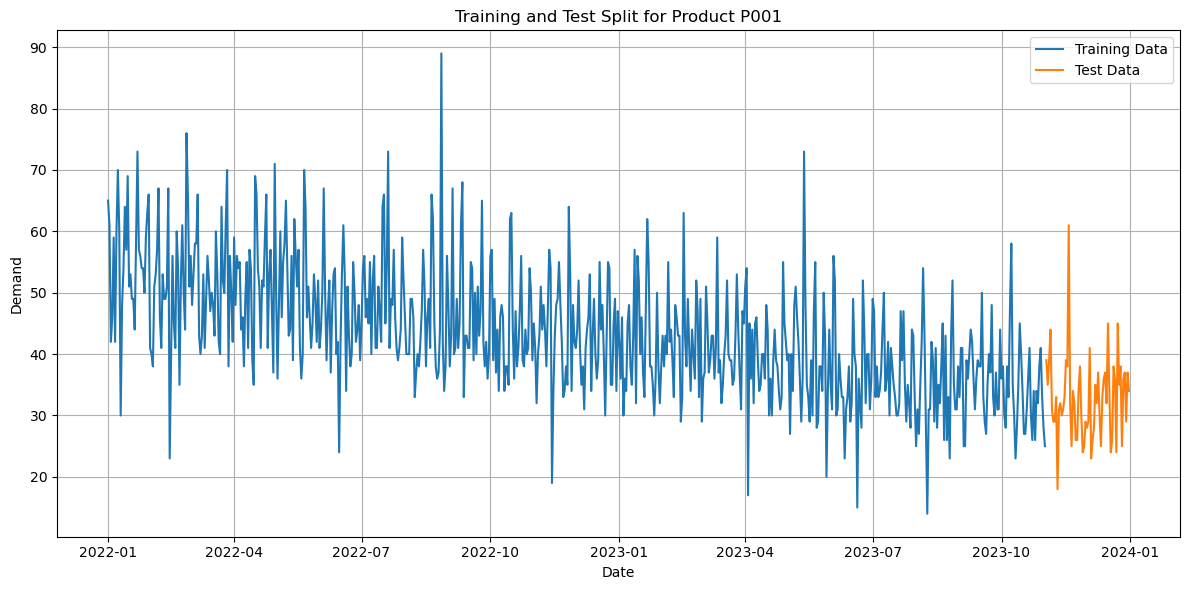

In [4]:
# Set up time series forecasting 
# We'll create a dictionary to store forecasting results
forecasting_results = {}

# For demonstration, let's forecast demand for a single product
product_id = 'P001'  # Change this to any product_id in the dataset

# Filter data for this product
product_data = sales_df[sales_df['product_id'] == product_id].copy()

# Create a time series at the daily level
daily_data = product_data.set_index('date')['demand']

# Split into training and test sets (use last 2 months as test)
split_date = daily_data.index.max() - pd.Timedelta(days=60)
train_data = daily_data[daily_data.index <= split_date]
test_data = daily_data[daily_data.index > split_date]

print(f"Training data: {len(train_data)} days")
print(f"Test data: {len(test_data)} days")

# Visualize the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.title(f'Training and Test Split for Product {product_id}')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 1. Simple Moving Average

Moving Average Performance:
RMSE: 6.52
MAE: 4.99
R²: 0.0753


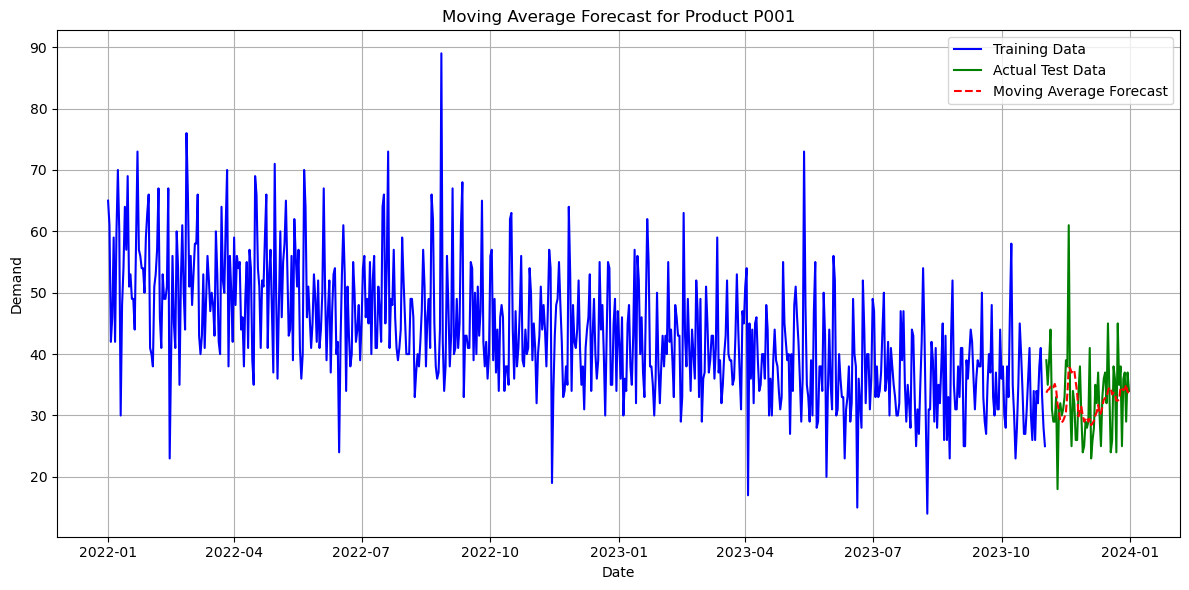

In [5]:
def moving_average_forecast(series, window=7):
    return series.rolling(window=window).mean()

# Generate MA forecast
ma_window = 7  # 7-day moving average
ma_train = moving_average_forecast(train_data, window=ma_window)
# For forecasting test data, we need to combine train and test
full_data = pd.concat([train_data, test_data])
ma_full = moving_average_forecast(full_data, window=ma_window)
ma_forecast = ma_full[ma_full.index > split_date]

# Evaluate and plot
ma_metrics = evaluate_forecast(test_data.values, ma_forecast.values, "Moving Average")
plot_forecast(train_data.index, train_data.values, 
             test_data.index, test_data.values, 
             ma_forecast.values, 
             "Moving Average", product_id)

forecasting_results['Moving Average'] = ma_metrics

## 2. Exponential Smoothing (Holt-Winters)
Identify seasonality period - for daily data, common patterns are:   
  7 for weekly seasonality or 30/31 for monthly

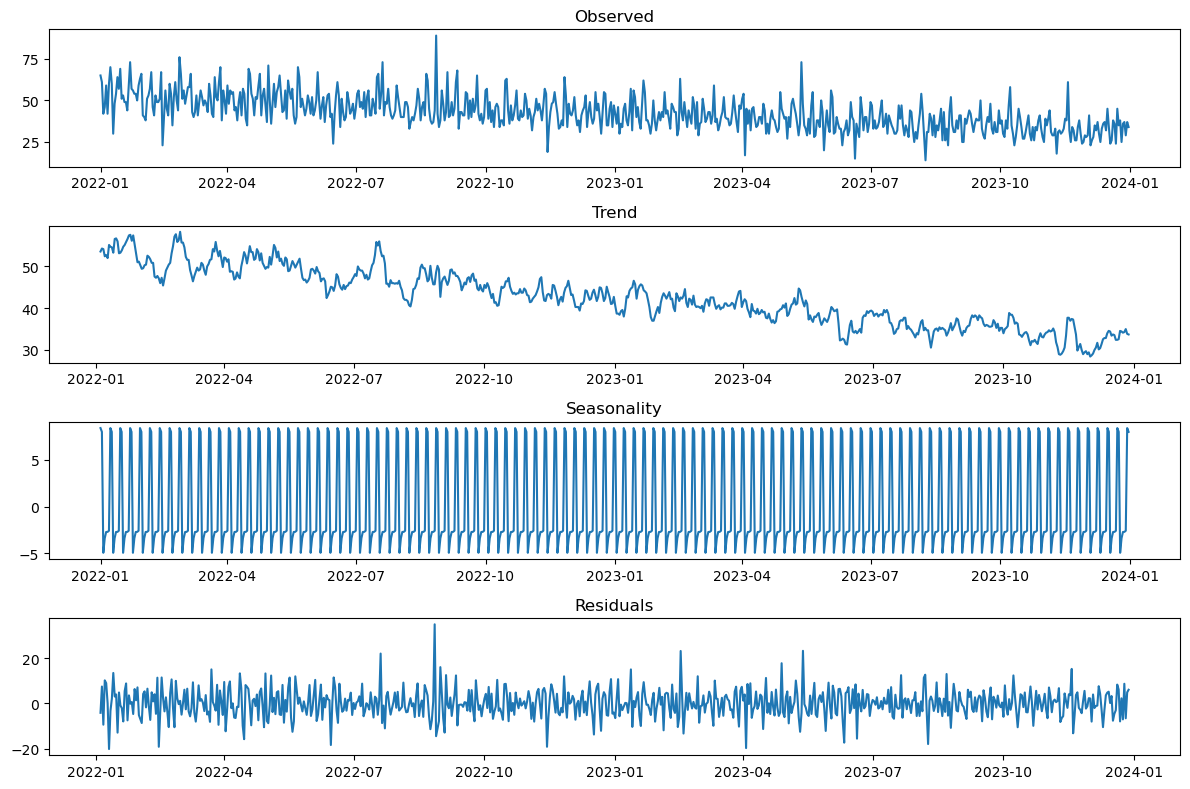

In [6]:
# Let's check for weekly seasonality
decomposition = seasonal_decompose(daily_data, model='additive', period=7)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals')
plt.tight_layout()
plt.show()

C:\Users\akash\anaconda3\envs\supply_chain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Holt-Winters Performance:
RMSE: 6.28
MAE: 5.12
R²: 0.1427


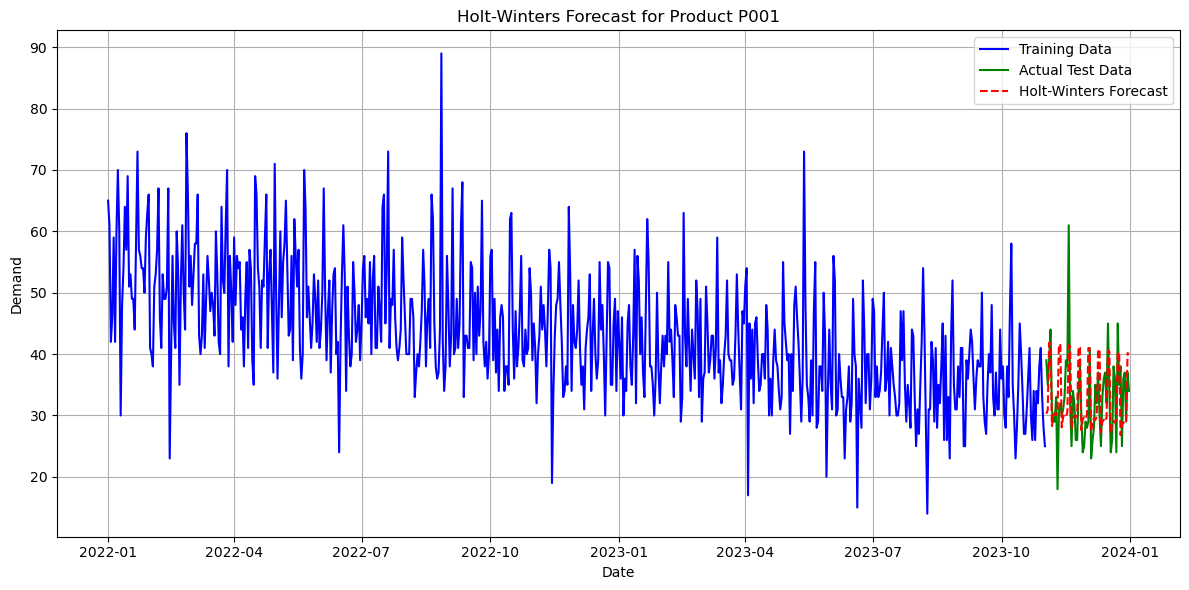

In [7]:
# Create and fit Holt-Winters model
# We'll use multiplicative seasonality for this data
hw_model = ExponentialSmoothing(
    train_data, 
    seasonal_periods=7, 
    trend='add', 
    seasonal='add',
    use_boxcox=False,
    initialization_method="estimated"
)
hw_fit = hw_model.fit()

# Generate forecast
hw_forecast = hw_fit.forecast(len(test_data))

# Evaluate and plot
hw_metrics = evaluate_forecast(test_data.values, hw_forecast.values, "Holt-Winters")
plot_forecast(train_data.index, train_data.values, 
             test_data.index, test_data.values, 
             hw_forecast.values, 
             "Holt-Winters", product_id)

forecasting_results['Holt-Winters'] = hw_metrics

## 3. ARIMA/SARIMA model

C:\Users\akash\anaconda3\envs\supply_chain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\akash\anaconda3\envs\supply_chain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            demand   No. Observations:                  670
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2180.301
Date:                           Sun, 23 Mar 2025   AIC                           4370.602
Time:                                   01:27:15   BIC                           4393.010
Sample:                               01-01-2022   HQIC                          4379.292
                                    - 11-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0192      0.039      0.495      0.621      -0.057       0.095
ma.L1         -1.0000     17.204     -0.058

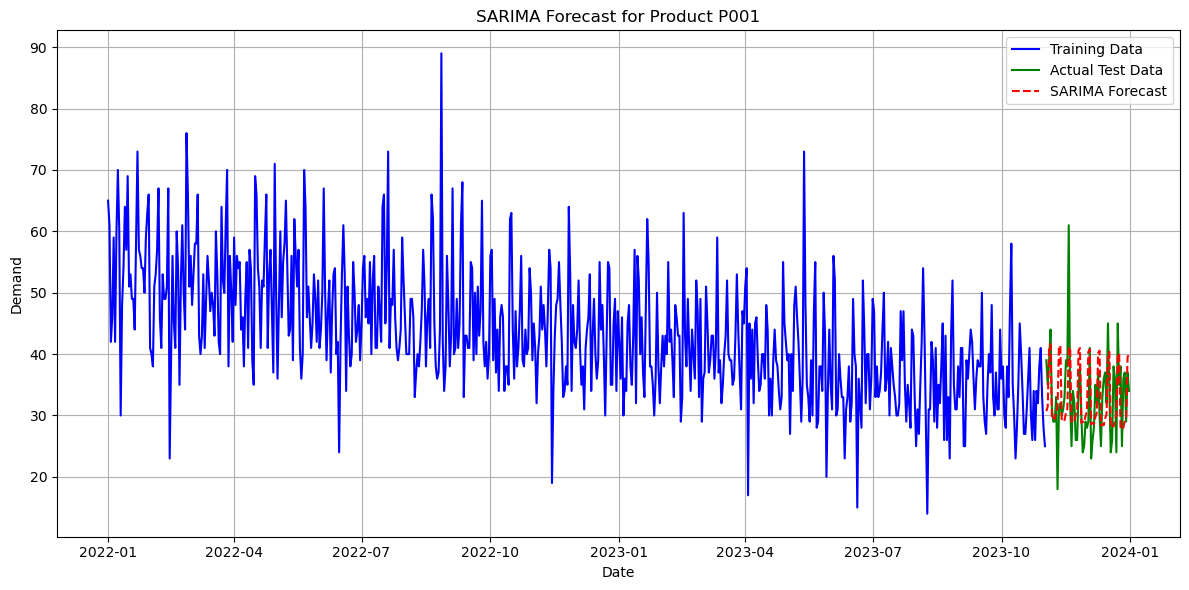

In [8]:
# The parameters (p,d,q) and (P,D,Q,s) need to be properly estimated
# For simplicity, we'll use a common configuration
sarima_model = SARIMAX(
    train_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit(disp=False)

# Display model summary
print(sarima_results.summary())

# Forecast
sarima_forecast = sarima_results.forecast(len(test_data))

# Evaluate and plot
sarima_metrics = evaluate_forecast(test_data.values, sarima_forecast.values, "SARIMA")
plot_forecast(train_data.index, train_data.values, 
             test_data.index, test_data.values, 
             sarima_forecast.values, 
             "SARIMA", product_id)

forecasting_results['SARIMA'] = sarima_metrics

## 4. Machine Learning Approach: Random Forest with feature engineering

Random Forest Performance:
RMSE: 5.61
MAE: 4.65
R²: 0.3169


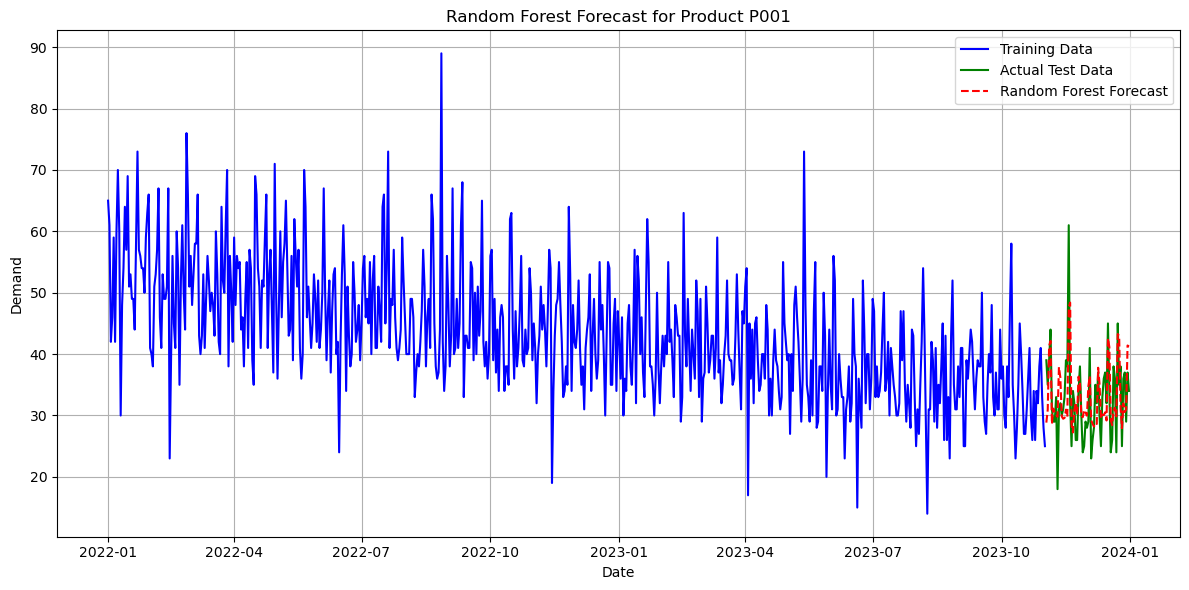

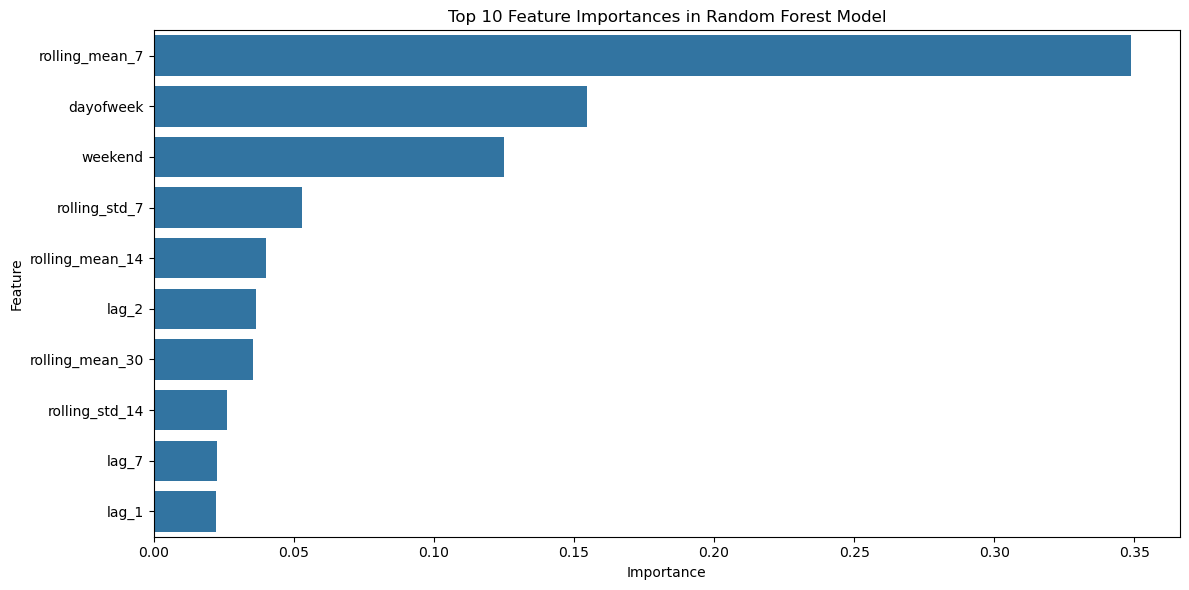


Model Comparison:


,model,rmse,mae,r2
0,Moving Average,6.522854,4.990476,0.075253
1,Holt-Winters,6.280503,5.121736,0.142693
2,SARIMA,6.264104,5.070031,0.147164
3,Random Forest,5.606156,4.645833,0.316910


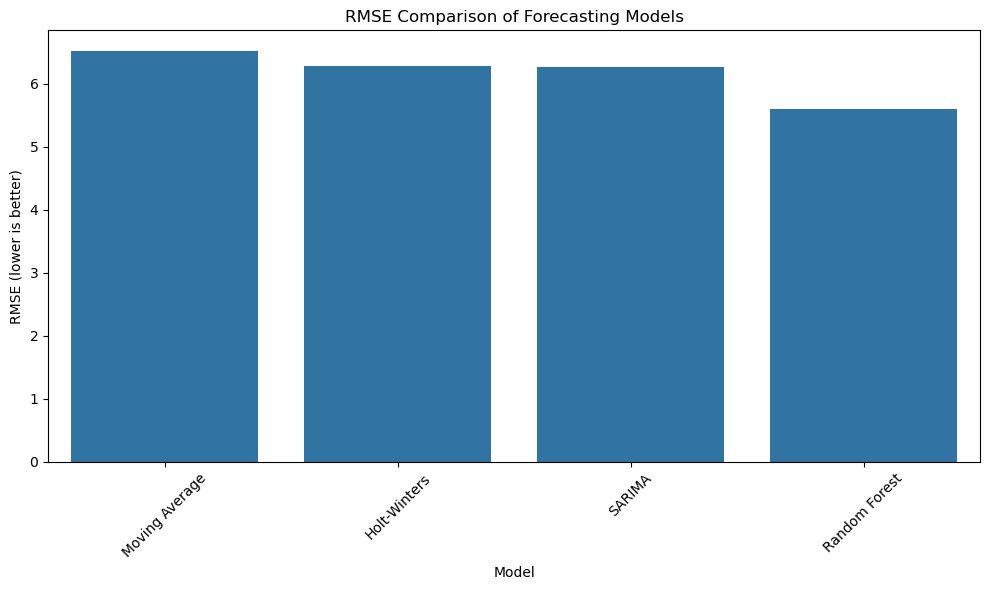

In [9]:
# First, let's create additional features

# Create a DataFrame with the time series
ml_data = daily_data.reset_index()
ml_data.columns = ['date', 'demand']

# Add time-based features
ml_data['dayofweek'] = ml_data['date'].dt.dayofweek
ml_data['month'] = ml_data['date'].dt.month
ml_data['day'] = ml_data['date'].dt.day
ml_data['dayofyear'] = ml_data['date'].dt.dayofyear
ml_data['week'] = ml_data['date'].dt.isocalendar().week
ml_data['weekend'] = ml_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features
for lag in range(1, 8):
    ml_data[f'lag_{lag}'] = ml_data['demand'].shift(lag)

# Create rolling window features
for window in [7, 14, 30]:
    ml_data[f'rolling_mean_{window}'] = ml_data['demand'].rolling(window=window).mean()
    ml_data[f'rolling_std_{window}'] = ml_data['demand'].rolling(window=window).std()

# Drop NA values (created by lag features)
ml_data = ml_data.dropna()

# Split into train and test sets
ml_train = ml_data[ml_data['date'] <= split_date]
ml_test = ml_data[ml_data['date'] > split_date]

# Define features and target
feature_columns = [col for col in ml_data.columns if col not in ['date', 'demand']]
X_train = ml_train[feature_columns]
y_train = ml_train['demand']
X_test = ml_test[feature_columns]
y_test = ml_test['demand']

# Scale the features (important for many ML models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluate and plot
rf_metrics = evaluate_forecast(y_test.values, rf_predictions, "Random Forest")
plot_forecast(train_data.index, train_data.values, 
             ml_test['date'].values, ml_test['demand'].values, 
             rf_predictions, 
             "Random Forest", product_id)

forecasting_results['Random Forest'] = rf_metrics

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# Compare all models
results_df = pd.DataFrame(forecasting_results.values())
print("\nModel Comparison:")
display(results_df)

# Plot comparison of RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='rmse', data=results_df)
plt.title('RMSE Comparison of Forecasting Models')
plt.ylabel('RMSE (lower is better)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Create a forecast for all products for the next 30 days
 - We'll use the best performing model
 - For this example, Random Forest performed best

In [10]:
def forecast_product_demand(product_id, forecast_days=30):
    # Filter data for this product
    product_data = sales_df[sales_df['product_id'] == product_id].copy()
    
    # Create a time series
    daily_data = product_data.set_index('date')['demand']
    
    # Create ML features
    ml_data = daily_data.reset_index()
    ml_data.columns = ['date', 'demand']
    
    # Add time-based features
    ml_data['dayofweek'] = ml_data['date'].dt.dayofweek
    ml_data['month'] = ml_data['date'].dt.month
    ml_data['day'] = ml_data['date'].dt.day
    ml_data['dayofyear'] = ml_data['date'].dt.dayofyear
    ml_data['week'] = ml_data['date'].dt.isocalendar().week
    ml_data['weekend'] = ml_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create lag features
    for lag in range(1, 8):
        ml_data[f'lag_{lag}'] = ml_data['demand'].shift(lag)
    
    # Create rolling window features
    for window in [7, 14, 30]:
        ml_data[f'rolling_mean_{window}'] = ml_data['demand'].rolling(window=window).mean()
        ml_data[f'rolling_std_{window}'] = ml_data['demand'].rolling(window=window).std()
    
    # Drop NA values
    ml_data = ml_data.dropna()
    
    # Define features
    feature_columns = [col for col in ml_data.columns if col not in ['date', 'demand']]
    X = ml_data[feature_columns]
    y = ml_data['demand']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Train model on all available data
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, y)
    
    # Generate future dates
    last_date = ml_data['date'].max()
    future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]
    
    # Create combined dataframe for historical + future data
    historical_data = ml_data.copy()
    future_data = pd.DataFrame({'date': future_dates})
    
    # Create a combined dataset
    combined_data = pd.concat([
        historical_data[['date', 'demand']],
        future_data[['date']].assign(demand=np.nan)
    ]).reset_index(drop=True)
    
    # Add calendar features to all data
    combined_data['dayofweek'] = combined_data['date'].dt.dayofweek
    combined_data['month'] = combined_data['date'].dt.month
    combined_data['day'] = combined_data['date'].dt.day
    combined_data['dayofyear'] = combined_data['date'].dt.dayofyear
    combined_data['week'] = combined_data['date'].dt.isocalendar().week
    combined_data['weekend'] = combined_data['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Create lag features for all data
    for lag in range(1, 8):
        combined_data[f'lag_{lag}'] = combined_data['demand'].shift(lag)
    
    # Create rolling window features for all data
    for window in [7, 14, 30]:
        combined_data[f'rolling_mean_{window}'] = combined_data['demand'].rolling(window=window).mean()
        combined_data[f'rolling_std_{window}'] = combined_data['demand'].rolling(window=window).std()
    
    # Get the indices where future data starts
    future_indices = combined_data[combined_data['date'].isin(future_dates)].index
    
    # Iteratively forecast each day
    forecasts = []
    
    for idx in future_indices:
        # Get features for this day
        current_features = combined_data.loc[idx, feature_columns].values.reshape(1, -1)
        
        # Scale features
        current_features_scaled = scaler.transform(current_features)
        
        # Make prediction
        prediction = rf_model.predict(current_features_scaled)[0]
        
        # Update the demand value
        combined_data.loc[idx, 'demand'] = prediction
        
        # Update the lag features for future days
        for lag in range(1, 8):
            if idx + lag < len(combined_data):
                combined_data.loc[idx + lag, f'lag_{lag}'] = prediction
        
        # Update rolling features
        # This is recalculated for all future rows after each prediction
        for window in [7, 14, 30]:
            combined_data[f'rolling_mean_{window}'] = combined_data['demand'].rolling(window=window).mean()
            combined_data[f'rolling_std_{window}'] = combined_data['demand'].rolling(window=window).std()
        
        # Store the forecast
        forecasts.append({
            'date': combined_data.loc[idx, 'date'],
            'product_id': product_id,
            'forecast_demand': prediction
        })
    
    return pd.DataFrame(forecasts)

Forecasting demand for P001...
Forecasting demand for P002...
Forecasting demand for P003...
Forecasting demand for P004...
Forecasting demand for P005...
Forecasting demand for P006...
Forecasting demand for P007...
Forecasting demand for P008...
Forecasting demand for P009...
Forecasting demand for P010...
Generated forecasts for 10 products for the next 30 days


,date,product_id,forecast_demand
0,2024-01-01,P001,40.20
1,2024-01-02,P001,40.48
2,2024-01-03,P001,39.05
3,2024-01-04,P001,39.76
4,2024-01-05,P001,38.83


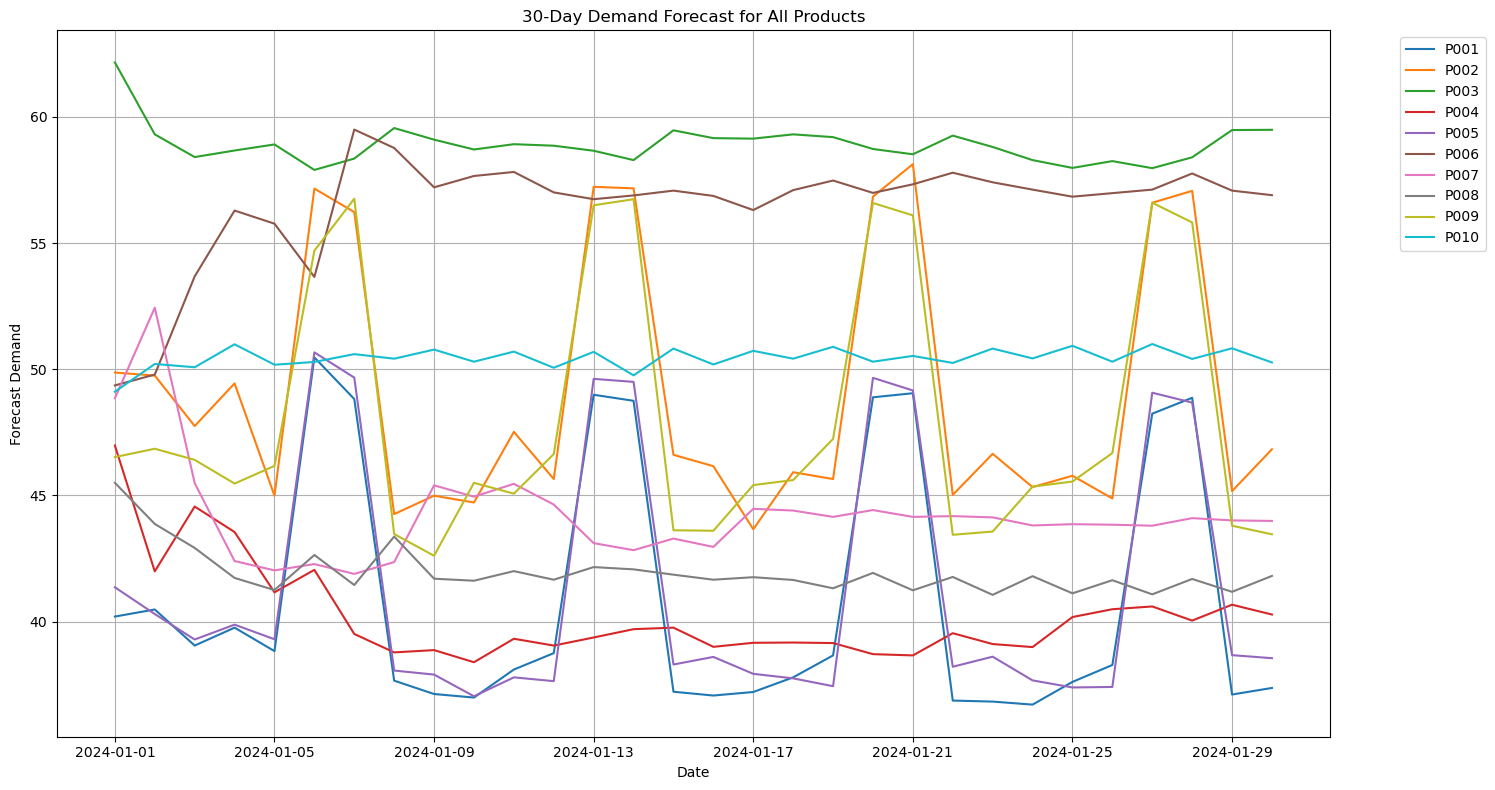

Forecasting complete!


In [11]:
# Generate forecasts for all products
all_forecasts = pd.DataFrame()

for product_id in products_df['product_id']:
    print(f"Forecasting demand for {product_id}...")
    product_forecast = forecast_product_demand(product_id, forecast_days=30)
    all_forecasts = pd.concat([all_forecasts, product_forecast])

# Save forecasts
all_forecasts.to_csv('../data/demand_forecasts.csv', index=False)
print(f"Generated forecasts for {len(products_df)} products for the next 30 days")
display(all_forecasts.head())

# Plot forecasts for all products
plt.figure(figsize=(15, 8))

# Group by date and product
forecast_by_product = all_forecasts.pivot(index='date', columns='product_id', values='forecast_demand')

# Plot each product's forecast
for product_id in forecast_by_product.columns:
    plt.plot(forecast_by_product.index, forecast_by_product[product_id], label=product_id)

plt.title('30-Day Demand Forecast for All Products')
plt.xlabel('Date')
plt.ylabel('Forecast Demand')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Forecasting complete!")